In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
#from AutoEncoderCNN import AE_CNN
from nn_trainer import ae_train

from util.custom_loss.custom_loss import mse_loss, sparsity_loss, dirichlet_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16790978560, 17059545088)

In [3]:
BATCH_SIZE = 4

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                      tensor_transform,
                                                                                                                      horizontal_flip
                                                                                                                    ]))


In [4]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
class AE_CNN(torch.nn.Module):
    def __init__(self, encoded_dim:int=2048, rand_mat_dim:int=1024, rand_mat = True) -> None:
        super().__init__()
        
        self.encoded_vector = None
        
        if rand_mat: 
            self.rand_mat = self.create_rand_mat(rand_mat_dim, encoded_dim)
        else:
            self.rand_mat = torch.randn(rand_mat_dim, encoded_dim, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu') # dummy rand matrix of correct dim
        
        self.softmax = torch.nn.Softmax()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3,16,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            torch.nn.Conv2d(16,32,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(32,64,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(64,128,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(2,stride=2, padding=1), 
            torch.nn.Conv2d(128,320,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(320,240,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(240,150,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(150,80,3,stride=2,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(80,40,3,stride=1,padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(40,15,3,stride=1,padding=1), # Outputs: 15 x 15 x 15
            torch.nn.ReLU(),
            
            
            torch.nn.Flatten(),
            torch.nn.Linear(15*15*15, encoded_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(rand_mat_dim, 15*15*15), # rand_mat_dim -> flattened dim
            torch.nn.Unflatten(1, (15, 15, 15)),
            
            torch.nn.ConvTranspose2d(15,40,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(40,80,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(80,150,3, stride=2, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(150,240,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(240,320,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(320,128,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(128,128,3, stride=2, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(128,64,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(64,64,3, stride=2, padding=2), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(64,32,3, stride=1, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(32,32,3, stride=2, padding=1), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(32,16,3, stride=1, padding=0), 
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(16,3,3, stride=1, padding=0), 
            torch.nn.Sigmoid()
        )
        
    def create_rand_mat(self, rand_mat_dim:int, encoded_dim:int) -> torch.tensor:
        y = torch.randn(rand_mat_dim, encoded_dim, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
        norm = torch.norm(y, dim = 0)
        for col in range(len(y[0])):
            for row in range(len(y)):
                y[row][col] /= norm[col]
        return y
        
    def forward(self, x) -> torch.tensor:
        self.encoded_vector = self.softmax(self.encoder(x))
        all_dps = []
        for batch in self.encoded_vector:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        decoded = self.decoder(Dp)
        return decoded

In [6]:
encoded_dim = 2048
rand_mat_dim = 1024 # try identity matrix

In [7]:
AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=True).to(device)

In [8]:
# AE.rand_mat = torch.eye(rand_mat_dim) # has to be square

In [9]:
AE

AE_CNN(
  (softmax): Softmax(dim=None)
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (11): Conv2d(128, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(320, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(240, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(150, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (18): ReLU()
    (19): Conv2d(80, 40, ke

In [10]:
AE.rand_mat

tensor([[-0.0218,  0.0087,  0.0391,  ..., -0.0130,  0.0358, -0.0012],
        [ 0.0844,  0.0075, -0.0250,  ..., -0.0031,  0.0332,  0.0058],
        [ 0.0423, -0.0245,  0.0137,  ..., -0.0526, -0.0106, -0.0040],
        ...,
        [ 0.0446,  0.0337,  0.0118,  ..., -0.0072, -0.0048,  0.0212],
        [-0.0187,  0.0371,  0.0080,  ...,  0.0090, -0.0278, -0.0389],
        [-0.0435, -0.0012, -0.0137,  ..., -0.0276, -0.0468,  0.0233]],
       device='cuda:0')

In [11]:
with open('progress.txt', 'w') as file:
    file.write(f"{AE=}\n\nTraining:\n")

In [12]:
EPOCHS = 100 # about 3.33/hr
loss_weights = [1, 0, 0] # chagne l2 to 1, 0.5, 0.1 ==> capped at 0.6
early_stop_depth = 25
verbose = 1

LR = [0.01, 0.001]
WEIGHT_DECAY = [0.1, 0.05, 0.005]

In [ ]:
torch.autograd.set_detect_anomaly(True)
min_loss = None
d = {}
for lr in LR:
    AE = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=True).to(device)
    #AE.rand_mat = torch.eye(rand_mat_dim)
    for wd in WEIGHT_DECAY:  
        with open('progress.txt', 'a') as file:
            file.write(f"{lr=} | {wd=}\n")
        optimizer = torch.optim.Adam(AE.parameters(), lr = lr, weight_decay = wd)
        outputs, loss_arr = ae_train(AE, train_loader, optimizer, EPOCHS, loss_weights, early_stop_depth, verbose)
        if loss_arr: # ignore nan
            d[str(lr) + "|"+str(wd)] = loss_arr[-1]
            if not min_loss or min_loss > loss_arr[-1]:
                min_loss = loss_arr[-1]
                torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
                torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')

                with open('progress.txt', 'a') as file:
                    file.write(f"New AE: {min_loss=}\n")
                print(f"New AE: {min_loss=}\n")

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/nn/functional.py:1881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch: 1 | Loss: 0.0484


Epoch: 2 | Loss: 0.0503


Epoch: 3 | Loss: 0.0492


Epoch: 4 | Loss: 0.0509


Epoch: 5 | Loss: 0.0463


Epoch: 6 | Loss: 0.0479


Epoch: 7 | Loss: 0.0459


Epoch: 8 | Loss: 0.0500


Epoch: 9 | Loss: 0.0551


Epoch: 10 | Loss: 0.0486


Epoch: 11 | Loss: 0.0451


Epoch: 12 | Loss: 0.0494


Epoch: 13 | Loss: 0.0487


Epoch: 14 | Loss: 0.0576


Epoch: 15 | Loss: 0.0439


Epoch: 16 | Loss: 0.0459


Epoch: 17 | Loss: 0.0520


Epoch: 18 | Loss: 0.0480


Epoch: 19 | Loss: 0.0496


Epoch: 20 | Loss: 0.0461


Epoch: 21 | Loss: 0.0554


Epoch: 22 | Loss: 0.0500


Epoch: 23 | Loss: 0.0443


Epoch: 24 | Loss: 0.0533


Epoch: 25 | Loss: 0.0476


Epoch: 26 | Loss: 0.0481


Epoch: 27 | Loss: 0.0512


Epoch: 28 | Loss: 0.0504


Epoch: 29 | Loss: 0.0496


Epoch: 30 | Loss: 0.0524


Epoch: 31 | Loss: 0.0565


Epoch: 32 | Loss: 0.0477


Epoch: 33 | Loss: 0.0500


Epoch: 34 | Loss: 0.0521


Epoch: 35 | Loss: 0.0487


Epoch: 36 | Loss: 0.0504


Epoch: 37 | Loss: 0.0509


Epoch: 38

In [14]:
#torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
if len(LR) == 1 and len(WEIGHT_DECAY) == 1: # dont save during grid search, should already be saved
    torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')
    torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')

    with open('progress.txt', 'a') as file:
        file.write(f"Saved\n\n")
    print("done")

done


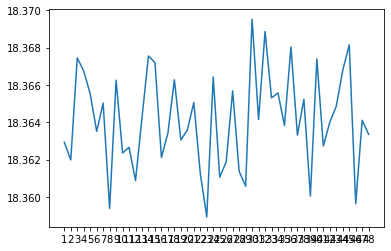

In [15]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.show()

In [16]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()

(15224406016, 17059545088)


In [7]:
torch.set_default_device('cuda')

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)


# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                      tensor_transform,
                                                                                                                      horizontal_flip
                                                                                                                    ]))
SPLIT = [528, 66, 66]
_, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

val_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=False).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [9]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup = model(inp)
        encoded_imgs = torch.mv(rand_mat, model.softmax(encoder(inp))[0])
        encoded_imgs_arr.append(encoded_imgs)
        
#         decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 1 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/nn/functional.py:1881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)


In [10]:
mse_running_total/len(val_loader)

0.05014948376143972

In [11]:
encoded_imgs_arr[0]

tensor([ 6.1692e-04,  9.2139e-04, -5.4188e-04,  ...,  8.6940e-04,
        -3.9211e-06,  6.7587e-04], device='cuda:0')

In [12]:
encoded_imgs_arr[1]

tensor([ 6.1692e-04,  9.2139e-04, -5.4188e-04,  ...,  8.6940e-04,
        -3.9211e-06,  6.7587e-04], device='cuda:0')

In [13]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

In [14]:
print(inp.size())

torch.Size([1, 3, 225, 225])


torch.Size([3, 225, 225])
0.04831410571932793


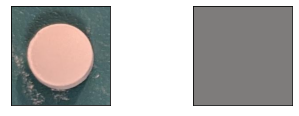

In [15]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

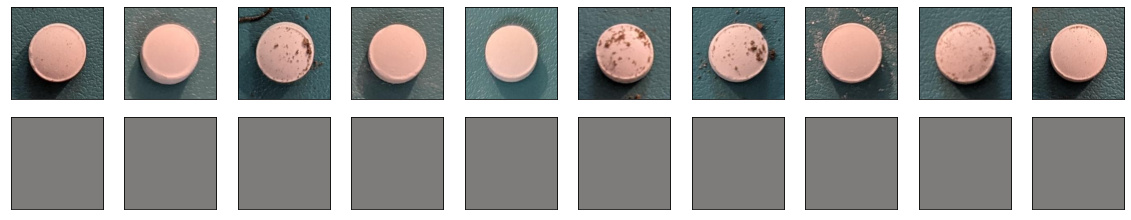

In [16]:
# Validation Set Images
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k+10][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [17]:
# Training between epochs
amt = len(outputs)
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = outputs[k][0][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = outputs[k][1][0].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

NameError: name 'outputs' is not defined

In [18]:
for i in range(len(auto_encoder_output)-1):
    recon1, recon2 = auto_encoder_output[i][1], auto_encoder_output[i+1][1]
    print(torch.sum(recon1 - recon2))

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='c